In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

DATA_DIR = "/content/drive/MyDrive/LSTM_Sequences/"



In [3]:
# ── Load data ─────────────────────────────────────────────────────────────── #
X_train = torch.tensor(np.load(f"{DATA_DIR}X_train.npy"), dtype=torch.float32)
y_train = torch.tensor(np.load(f"{DATA_DIR}y_train.npy"), dtype=torch.float32)
X_val   = torch.tensor(np.load(f"{DATA_DIR}X_val.npy"),   dtype=torch.float32)
y_val   = torch.tensor(np.load(f"{DATA_DIR}y_val.npy"),   dtype=torch.float32)
X_test  = torch.tensor(np.load(f"{DATA_DIR}X_test.npy"),  dtype=torch.float32)
y_test  = torch.tensor(np.load(f"{DATA_DIR}y_test.npy"),  dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=False)
val_loader   = DataLoader(TensorDataset(X_val,   y_val),   batch_size=64, shuffle=False)



In [4]:
# ── Model ─────────────────────────────────────────────────────────────────── #
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return out.squeeze(-1)

# ── Helper ────────────────────────────────────────────────────────────────── #
def evaluate(loader):
    model.eval()
    total_mse, total_mae, n = 0.0, 0.0, 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            total_mse += nn.MSELoss(reduction="sum")(preds, y_batch).item()
            total_mae += nn.L1Loss(reduction="sum")(preds, y_batch).item()
            n += len(y_batch)
    return total_mse / n, total_mae / n

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = LSTMModel(input_size=X_train.shape[2]).to(device)
print(model)

LSTMModel(
  (lstm): LSTM(8, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [5]:
# ── Training ──────────────────────────────────────────────────────────────── #
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
criterion = nn.MSELoss()

history = {
    "train_loss": [], "val_loss": [],
    "train_mae":  [], "val_mae":  [],
}

best_val_loss = float("inf")
patience, patience_counter = 10, 0

for epoch in range(100):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        loss = criterion(model(X_batch), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    _, train_mae      = evaluate(train_loader)
    val_loss, val_mae = evaluate(val_loader)

    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_mae"].append(train_mae)
    history["val_mae"].append(val_mae)

    print(f"Epoch {epoch+1:03d} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train MAE: {train_mae:.4f} | Val MAE: {val_mae:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), f"{DATA_DIR}lstm_best.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

Epoch 001 | Train Loss: 1.6529 | Val Loss: 1.1804 | Train MAE: 0.8445 | Val MAE: 0.8807
Epoch 002 | Train Loss: 1.3674 | Val Loss: 1.1298 | Train MAE: 0.8312 | Val MAE: 0.8651
Epoch 003 | Train Loss: 1.2652 | Val Loss: 1.0908 | Train MAE: 0.8217 | Val MAE: 0.8521
Epoch 004 | Train Loss: 1.1915 | Val Loss: 1.0556 | Train MAE: 0.8145 | Val MAE: 0.8392
Epoch 005 | Train Loss: 1.1432 | Val Loss: 1.0390 | Train MAE: 0.8114 | Val MAE: 0.8338
Epoch 006 | Train Loss: 1.0989 | Val Loss: 1.0277 | Train MAE: 0.8088 | Val MAE: 0.8293
Epoch 007 | Train Loss: 1.0724 | Val Loss: 1.0194 | Train MAE: 0.8061 | Val MAE: 0.8261
Epoch 008 | Train Loss: 1.0505 | Val Loss: 1.0014 | Train MAE: 0.8022 | Val MAE: 0.8181
Epoch 009 | Train Loss: 1.0312 | Val Loss: 0.9984 | Train MAE: 0.7992 | Val MAE: 0.8164
Epoch 010 | Train Loss: 1.0162 | Val Loss: 1.0013 | Train MAE: 0.7986 | Val MAE: 0.8183
Epoch 011 | Train Loss: 1.0060 | Val Loss: 0.9860 | Train MAE: 0.7952 | Val MAE: 0.8118
Epoch 012 | Train Loss: 0.9961 |

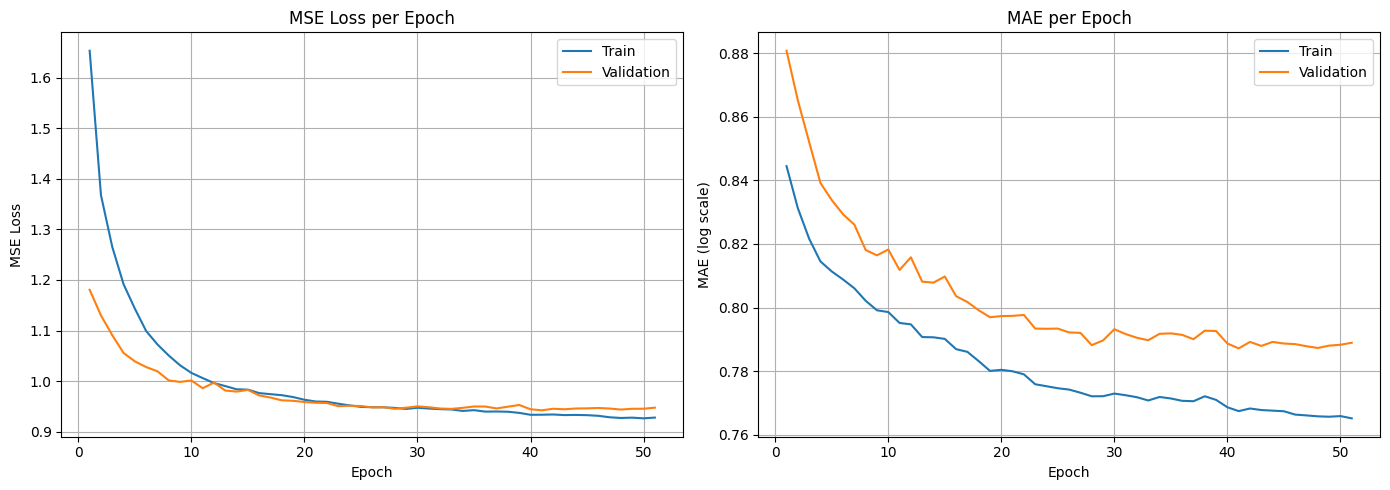

In [6]:
# ── Plot ──────────────────────────────────────────────────────────────────── #
epochs = range(1, len(history["train_loss"]) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(epochs, history["train_loss"], label="Train")
ax1.plot(epochs, history["val_loss"],   label="Validation")
ax1.set_title("MSE Loss per Epoch")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MSE Loss")
ax1.legend()
ax1.grid(True)

ax2.plot(epochs, history["train_mae"], label="Train")
ax2.plot(epochs, history["val_mae"],   label="Validation")
ax2.set_title("MAE per Epoch")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("MAE (log scale)")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig(f"{DATA_DIR}lstm_training_curves.png", dpi=150, bbox_inches="tight")
plt.show()

In [7]:
# ── Evaluate ──────────────────────────────────────────────────────────────── #
model.load_state_dict(torch.load(f"{DATA_DIR}lstm_best.pt"))
model.eval()

with torch.no_grad():
    y_pred_log = model(X_test.to(device)).cpu().numpy()

y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test.numpy())

mae  = np.mean(np.abs(y_pred - y_true))
rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
print(f"\nTest MAE:  {mae:.2f} days")
print(f"Test RMSE: {rmse:.2f} days")


Test MAE:  47.52 days
Test RMSE: 84.39 days
